# Regression models with Champagne sales dataset

**Apply the same code used with the Airline passengers dataset to the Champagne monthly sales dataset, to see the impact of traditional regression models on a different type of data. So there is no new code, only a new dataset.**

**Since we already know that the Champagne data is stationary when differenced, you should difference the values, but in this exercise we will only log-transform the values.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [3]:
df = pd.read_csv('data/perrin-freres-monthly-champagne.csv', index_col='Month', skipfooter=2, parse_dates=True, engine='python')

In [4]:
# Rename column

df.columns = ['Sales']

In [5]:
# Log-transform time series

df['LogSales'] = np.log(df['Sales'])

In [6]:
df.head()

,Sales,LogSales
Month,,
1964-01-01,2815,7.942718
1964-02-01,2672,7.890583
1964-03-01,2755,7.921173
1964-04-01,2721,7.908755
1964-05-01,2946,7.988204


**NOTE THAT TIME SERIES IS NOT DIFFERENCED.**

In [7]:
# Create training and test sets

N_test = 12

train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [8]:
# Make 'supervised' dataset - use T past values to predict the next value

series = df['LogSales'].to_numpy()

T = 12
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (93, 12) Y.shape (93,)


In [9]:
# Split X and Y into X_train, y_train, X_test, y_test

X_train, y_train = X[:-N_test], Y[:-N_test]

X_test, y_test = X[-N_test:], Y[-N_test:]

## Linear Regression model

In [10]:
lr = LinearRegression()

lr.fit(X_train, y_train)

print("Train R2 score:", lr.score(X_train, y_train))

Train R2 score: 0.8682372095558998


In [11]:
print("Test R2 score:", lr.score(X_test, y_test))

Test R2 score: 0.9657520752272795


**Very good scores, in fact it is highly unusual to get a higher test score - by approx. 10%!**

In [12]:
# Boolean index

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

# First T values are not predictable
train_idx[:T] = False 

### One-step forecast

In [13]:
df.loc[train_idx, 'LR_1step_train'] = lr.predict(X_train)

df.loc[test_idx, 'LR_1step_test'] = lr.predict(X_test)

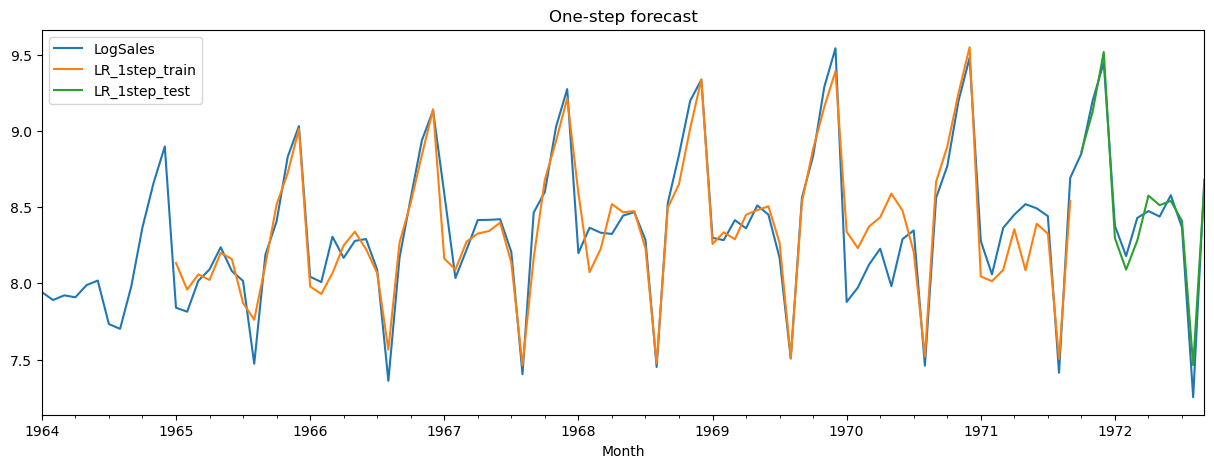

In [14]:
# Plot 1-step forecast

df[['LogSales', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5))
plt.title("One-step forecast");

**That looks pretty good, but remember this is just the one-step forecast.**

### Incremental Multi-step forecast

In [16]:
multistep_predictions = []

# First test input
last_x = X_test[0]

while len(multistep_predictions) < N_test:
    p = lr.predict(last_x.reshape(1, -1))[0]
    
    # Update the predictions list
    multistep_predictions.append(p)
    
    # Make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [17]:
# Save multi-step forecast to dataframe

df.loc[test_idx, 'LR_multistep'] = multistep_predictions

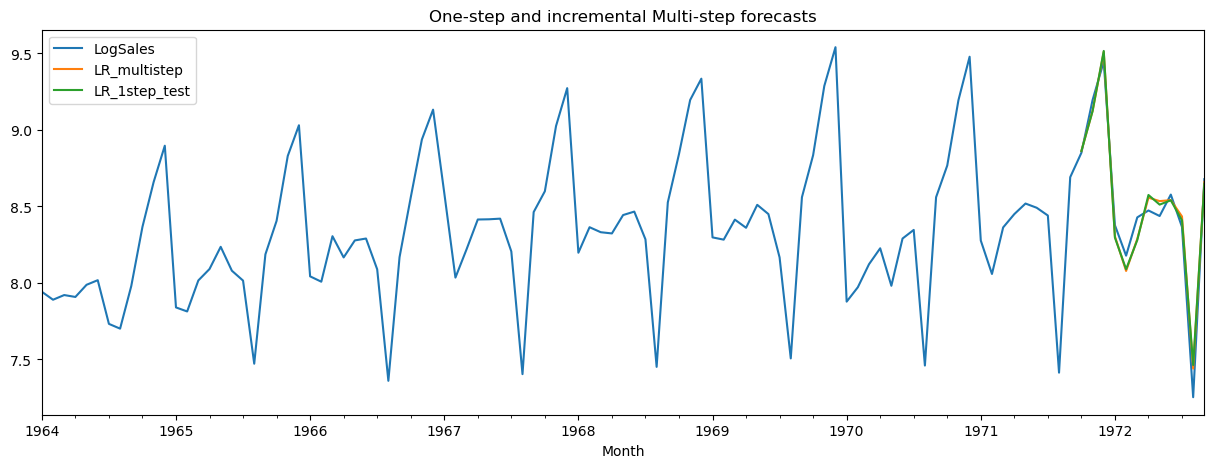

In [18]:
# Plot 1-step and multi-step forecast

df[['LogSales', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5))
plt.title("One-step and incremental Multi-step forecasts");

**Both forecasts look good, in fact they are practically the same!**

### Multi-output Multi-step forecast

In [19]:
# Make multi-output supervised dataset with multiple targets per row

Tx = T
Ty = N_test
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (82, 12) Y.shape (82, 12)


In [20]:
# Split X and Y into Xtrain, Ytrain, Xtest, Ytest

Xtrain, Ytrain = X[:-1], Y[:-1]

Xtest, Ytest = X[-1:], Y[-1:]

In [21]:
# Re-train Linear Regression model

lr = LinearRegression()

lr.fit(Xtrain, Ytrain)

print("Train R2 score:", lr.score(Xtrain, Ytrain))

Train R2 score: 0.8829262390390559


In [22]:
print("Test R2 score:")

r2_score(lr.predict(Xtest).flatten(), Ytest.flatten())

Test R2 score:


0.959510787915843

**R-Squared scores for the training and test model accuracy are very good again, similar to one-step and incremental multi-step, with higher test score than training score.**

In [23]:
# Save multi-output forecast to dataframe

df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest).flatten()

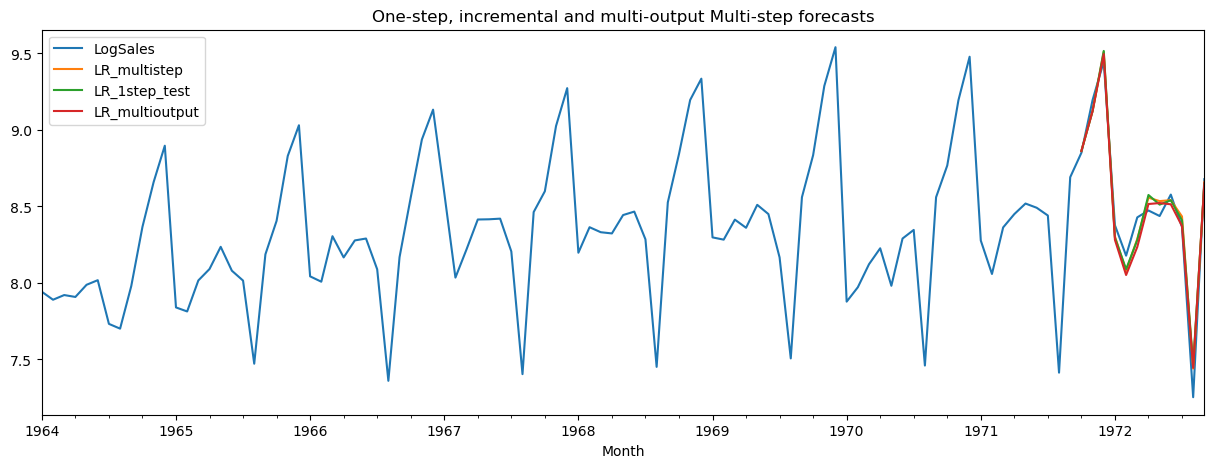

In [24]:
# Plot all forecasts

cols = ['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']

df[cols].plot(figsize=(15, 5))
plt.title("One-step, incremental and multi-output Multi-step forecasts");

**All three forecasts look good, as well as similar, so it is hard to confirm the best choice unless you calculate a regression metric, like `MAPE`.**

In [25]:
# Compute MAPE

mape1 = mean_absolute_percentage_error(y_test, multistep_predictions)
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(y_test, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.00960716937379765
multi-output MAPE: 0.009727020853255842


**As expected, the MAPE scores are very close, with incremental multi-step forecasts performing a little better, interestingly enough, since it is usually the multi-output method that outperforms.**

## Test other regression models

In [26]:
# Function to generate one-step and incremental multi-step forecasts

def one_step_and_multistep_forecast(model, name):
    model.fit(X_train, y_train)
    print("One-step forecast:", name)
    print("Train R^2:", model.score(X_train, y_train))
    print("Test R^2 (1-step):", model.score(X_test, y_test))
    
    # Store 1-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = model.predict(X_train)
    df.loc[test_idx, f'{name}_1step_test'] = model.predict(X_test)
    
    # Generate incremental multi-step forecast
    multistep_predictions = []
    
    # Obtain first test input
    last_x = X_test[0]
    
    while len(multistep_predictions) < N_test:
        p = model.predict(last_x.reshape(1, -1))[0]
        
        # Update the predictions list
        multistep_predictions.append(p)
        
        # Make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p
        
    # Store multi-step forecast
    df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions
    
    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(y_test, multistep_predictions)
    print("Test MAPE (multi-step):", mape)
    
    # Plot 1-step and multi-step forecast
    cols = ['LogSales', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']
    df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Train R^2: 0.9537658881175697
Test R^2 (1-step): 0.9216636120320177
Test MAPE (multi-step): 0.013188370472848111


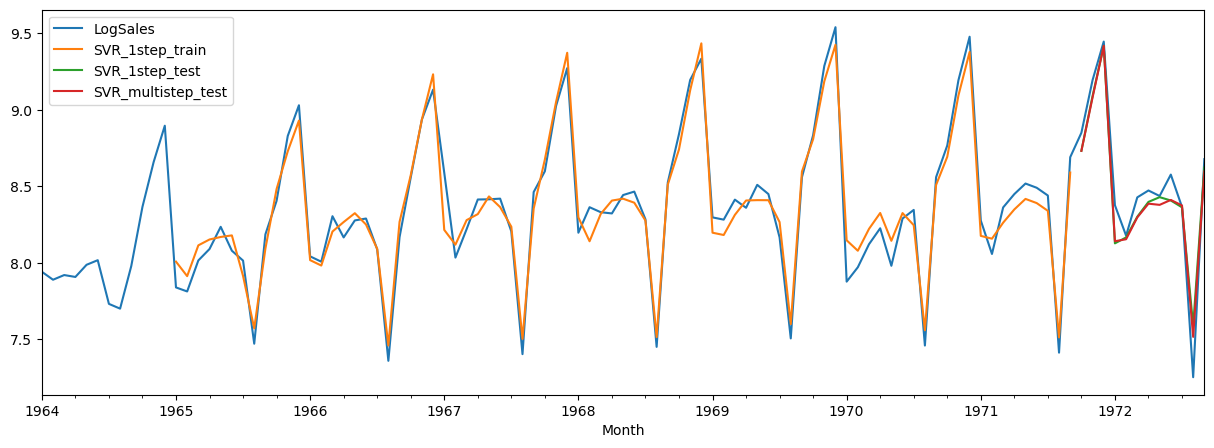

In [27]:
one_step_and_multistep_forecast(SVR(), "SVR")

**Support Vector Machine does pretty well with the one-step forecasts scoring pretty high. The incremental multi-step forecasts look practically the same but scores worse on the MAPE metric than Linear Regression.**

One-step forecast: RF
Train R^2: 0.9779746278783061
Test R^2 (1-step): 0.9558571596390362
Test MAPE (multi-step): 0.010642134461314326


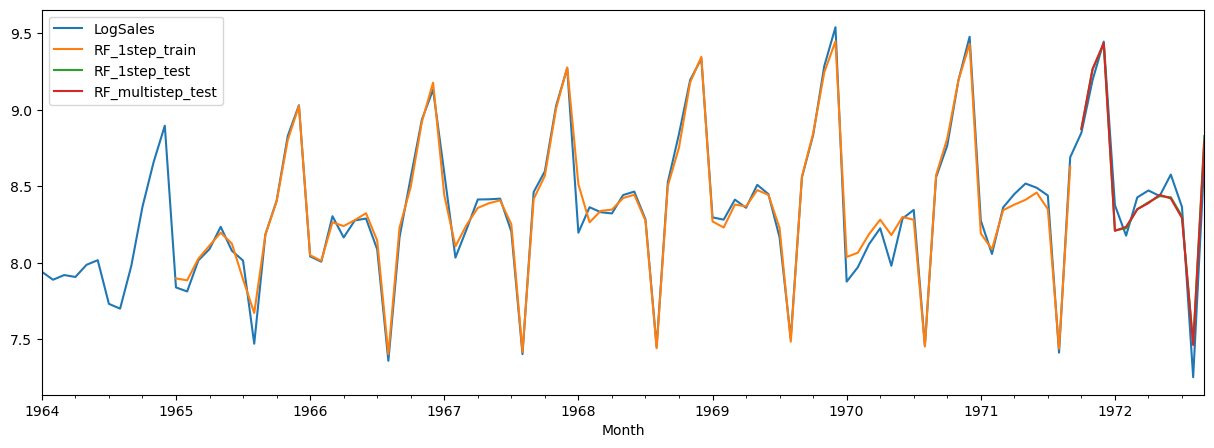

In [28]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

**Random Forests also performs well, especially for one-step forecasts, but scores the same as SVR on the incremental multi-step forecasts - worse than Linear Regression.**

In [31]:
def multi_output_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    
    # Save multi-output forecast to dataframe
    df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest).flatten()
    
    mape = mean_absolute_percentage_error(y_test, df.loc[test_idx, f'{name}_multioutput'])
    print("Test MAPE (multi-output):", mape)
    
    # Plot all forecasts assuming that previous functions have been run
    cols = ['LogSales', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test', f'{name}_multioutput']
    df[cols].plot(figsize=(15, 5));

Test MAPE (multi-output): 0.02089265655629878


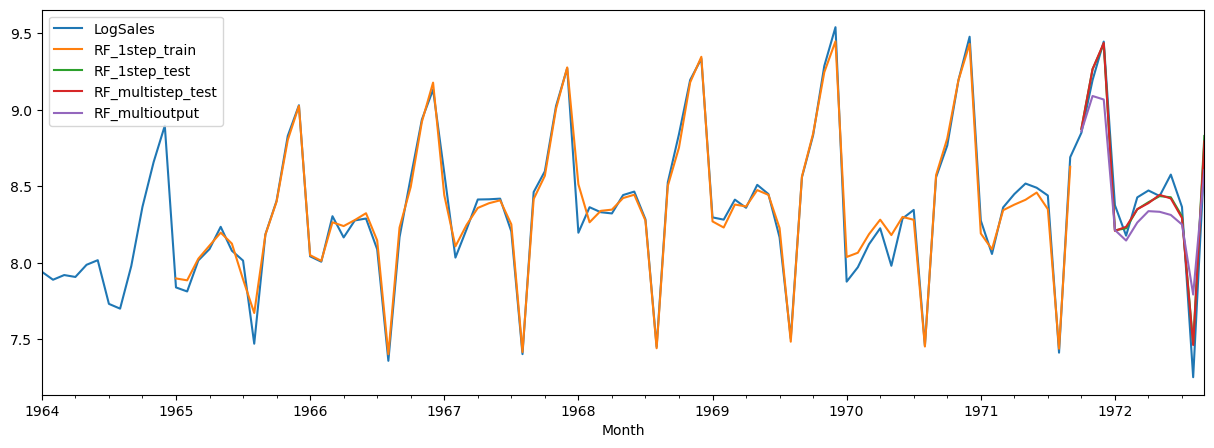

In [32]:
multi_output_forecast(RandomForestRegressor(), "RF")

**For multi-output multi-step forecast, the Random Forest does not score as well on the MAPE metric compared to Linear Regression (0.0092), and the multi-output predictions do not reach the peak as the other forecasts do for Random Forest.**

**NOTE: Support Vector Machine cannot handle multiple outputs - you need the `SVRWrapper` to generate the multi-output multi-step forecasts.**

**In conclusion, the Linear Regression with incremental multi-step forecasting (MAPE=0.00960) was the best model based on un-differenced data.**



## Regression models with data differenced

**Since you can copy the code directly from the airline passengers exercise, try differencing the champagne data before training the models, to ensure that the time series is stationary. Remember that you need to undo the differencing before forecasting.**

In [34]:
# Re-load dataframe to start fresh

doc = pd.read_csv('data/perrin-freres-monthly-champagne.csv', 
                   index_col='Month', 
                   skipfooter=2, 
                   parse_dates=True, 
                   engine='python')

In [35]:
# Rename column

doc.columns = ['Sales']

In [36]:
doc['LogSales'] = np.log(doc['Sales'])

In [37]:
# Difference the logged sales

doc['DiffLogSales'] = doc['LogSales'].diff()

In [38]:
# Note first null value in diffed column

doc.head()

,Sales,LogSales,DiffLogSales
Month,,,
1964-01-01,2815,7.942718,NaN
1964-02-01,2672,7.890583,-0.052135
1964-03-01,2755,7.921173,0.030590
1964-04-01,2721,7.908755,-0.012418
1964-05-01,2946,7.988204,0.079449


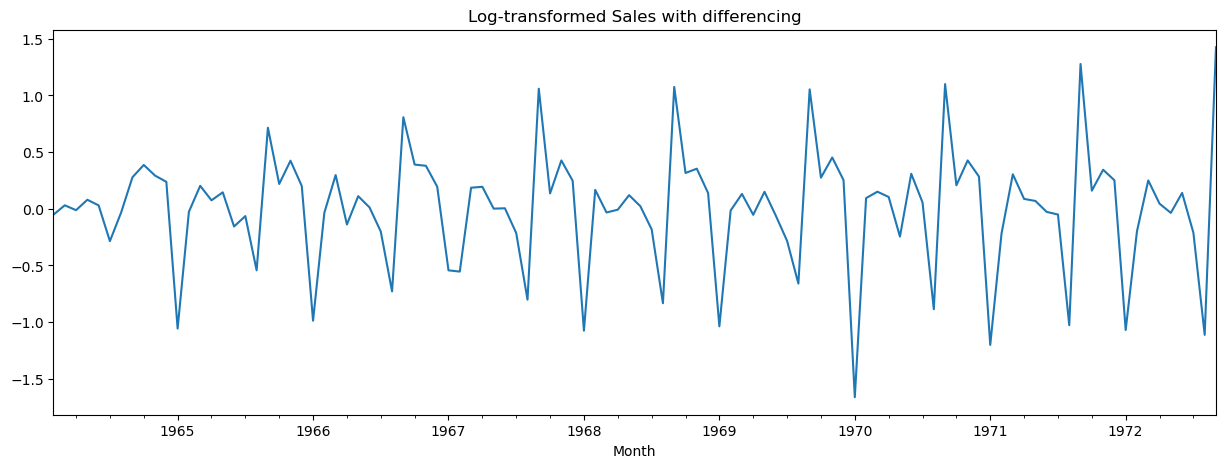

In [71]:
doc['DiffLogSales'][1:].plot(figsize=(15, 5))
plt.title("Log-transformed Sales with differencing");

In [41]:
# Create training and test sets

Ntest = 12

train = doc.iloc[: -Ntest]
test = doc.iloc[-Ntest :]

In [42]:
# Make supervised one-step dataset to train model - use T past values to predict the next value

# Differenced data without first value (null)
series = doc['DiffLogSales'].to_numpy()[1:]

T = 12
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)


In [43]:
# Convert to NumPy arrays

X = np.array(X).reshape(-1, T)
Y = np.array(Y)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (92, 12) Y.shape (92,)


In [44]:
# Split X and Y into Xtrain_d, Ytrain_d, Xtest_d, Ytest_d

Xtrain_d, Ytrain_d = X[:-Ntest], Y[:-Ntest]

Xtest_d, Ytest_d = X[-Ntest:], Y[-Ntest:]

### Linear Regression model

In [45]:
logreg = LinearRegression()

# Train model on diffed values
logreg.fit(Xtrain_d, Ytrain_d)

print("Train R2 score:", logreg.score(Xtrain_d, Ytrain_d))

Train R2 score: 0.8956166443316613


In [46]:
print("Test R2 score:", logreg.score(Xtest_d, Ytest_d))

Test R2 score: 0.9747509300506134


**Again, good model accuracy but very similar to Linear Regression with un-differenced data.**

In [47]:
# Boolean index train and test sets against original data

train_idx = doc.index <= train.index[-1]
test_idx = ~train_idx

# Initial T + 1 values are not predictable (+1 because of differencing)
train_idx[:T + 1] = False 

In [48]:
# Compute un-diffed predictions by shifting logged passengers up by one (previous value)

doc['ShiftLogSales'] = doc['LogSales'].shift(1)

prev = doc['ShiftLogSales']

In [49]:
# Obtain last-known training set value (for multi-step forecast)

last_train = train.iloc[-1]['LogSales']

#### One-step forecast

In [50]:
# Add shifted values to predictions (only applies to 1-step forecast)

doc.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + logreg.predict(Xtrain_d)

doc.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + logreg.predict(Xtest_d)

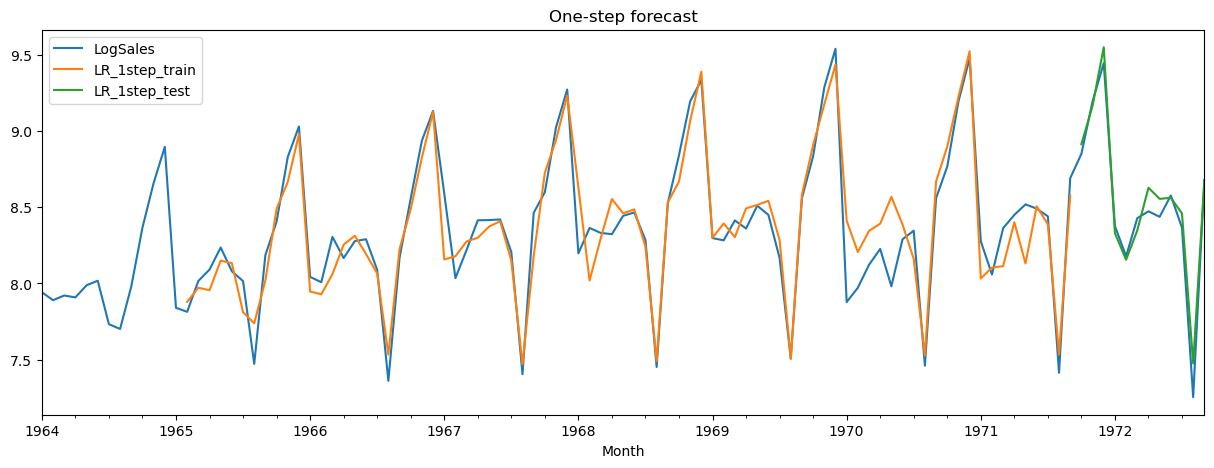

In [51]:
# Plot 1-step forecast

doc[['LogSales', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5))
plt.title("One-step forecast");

**One-step forecasts look pretty good, and follow the true data closely.**

#### Incremental Multi-step forecast

**Generate the incremental multi-step predictions:**

In [52]:
multistep_predictions = []

# Obtain first test input
last_x = Xtest_d[0]

while len(multistep_predictions) < Ntest:
    p = logreg.predict(last_x.reshape(1, -1))[0]
    
    # Update the predictions list
    multistep_predictions.append(p)
    
    # Make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [53]:
# Save multi-step forecast to dataframe as last-known train value plus cumulative sum of differences

doc.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

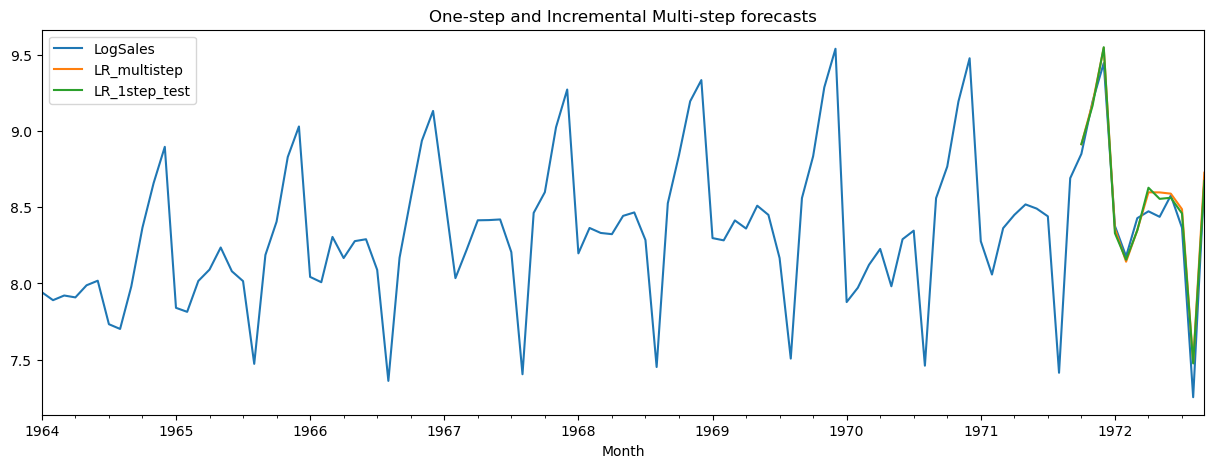

In [54]:
# Plot 1-step and multi-step forecast together

doc[['LogSales', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5))
plt.title("One-step and Incremental Multi-step forecasts");

**Incremental seems to perform slightly better than one-step forecasts.**

#### Multi-output Multi-step forecast

**Compare the incremental multi-step forecast with the multi-output method.**

In [55]:
# Make new multi-output supervised dataset

Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t : t + Tx]
    X.append(x)
    y = series[t + Tx : t + Tx + Ty]
    Y.append(y)


In [56]:
# Convert to NumPy arrays

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (81, 12) Y.shape (81, 12)


In [60]:
# Split X and Y into X_train_d, Y_train_d, X_test_d, Y_test_d

X_train_d, Y_train_d = X[:-1], Y[:-1]

X_test_d, Y_test_d = X[-1:], Y[-1:]

In [61]:
# Re-train model on multi-output data

logreg = LinearRegression()

logreg.fit(X_train_d, Y_train_d)

print("Train R2 score:", logreg.score(X_train_d, Y_train_d))

Train R2 score: 0.8540992348667288


In [62]:
# Need to compute outside the model for test set

r2_score(logreg.predict(X_test_d).flatten(), Y_test_d.flatten())

0.9490424816243255

In [63]:
# Save multi-output forecast to dataframe as last-known train value plus cumulative sum of differences

doc.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(logreg.predict(X_test_d).flatten())

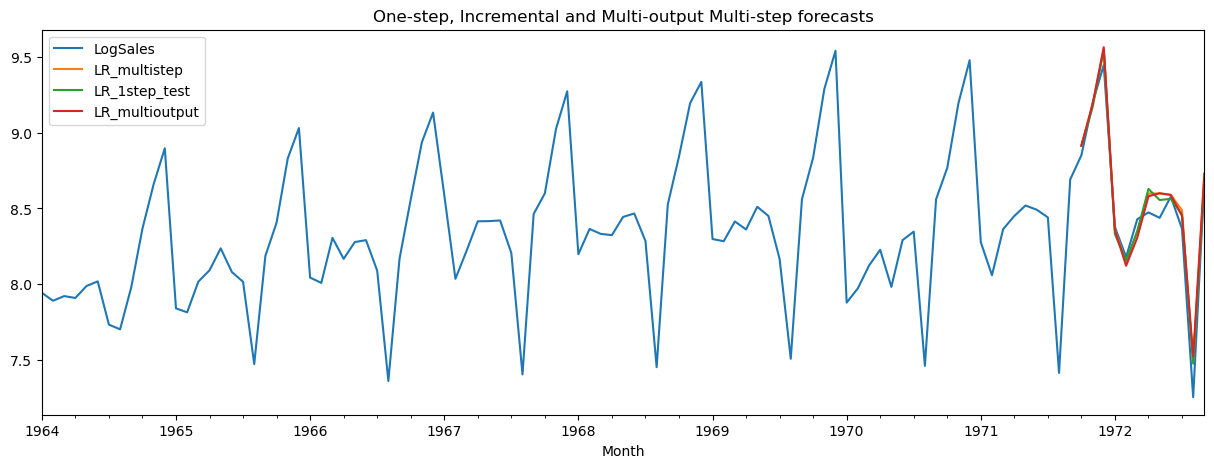

In [64]:
# Plot all forecasts

cols = ['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']

doc[cols].plot(figsize=(15, 5))
plt.title("One-step, Incremental and Multi-output Multi-step forecasts");

In [65]:
# Compute MAPE

test_log_pass = doc.iloc[-Ntest :]['LogSales']

mape_1 = mean_absolute_percentage_error(test_log_pass, doc.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape_1)

mape_2 = mean_absolute_percentage_error(test_log_pass, doc.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape_2)

multi-step MAPE: 0.01014253285484796
multi-output MAPE: 0.010888891335243468


**The multi-output forecasts are almost exactly the same as one-step forecasts. So again, the incremental method performs best, for differenced Sales data (MAPE=0.01014). However, Linear Regression with un-differenced data outperforms them all so far.**

### Test other regression models

In [66]:
# Function to return one-step and incremental multi-step forecasts

def one_step_and_multistep_forecast_diff(model, name):
    model.fit(Xtrain_d, Ytrain_d)
    print("One-step forecast:", name)
    print("Train R^2:", model.score(Xtrain_d, Ytrain_d))
    print("Test R^2 (1-step):", model.score(Xtest_d, Ytest_d))
    
    # Store 1-step forecast
    doc.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + model.predict(Xtrain_d)
    doc.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + model.predict(Xtest_d)
    
    # Generate multi-step forecast
    multistep_predictions = []
    
    # First test input
    last_x = Xtest_d[0]
    
    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1, -1))[0]
        
        # Update the predictions list
        multistep_predictions.append(p)
        
        # Make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p
        
    # Store multi-step forecast
    doc.loc[test_idx, f'{name}_multistep_test'] = last_train + np.cumsum(multistep_predictions)
    
    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(test_log_pass, doc.loc[test_idx, f'{name}_multistep_test'])
    print("Test MAPE (multi-step):", mape)
    
    # Plot 1-step and multi-step forecast
    cols = ['LogSales', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']
    doc[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Train R^2: 0.949532148089443
Test R^2 (1-step): 0.9591696612867915
Test MAPE (multi-step): 0.013025526903658352


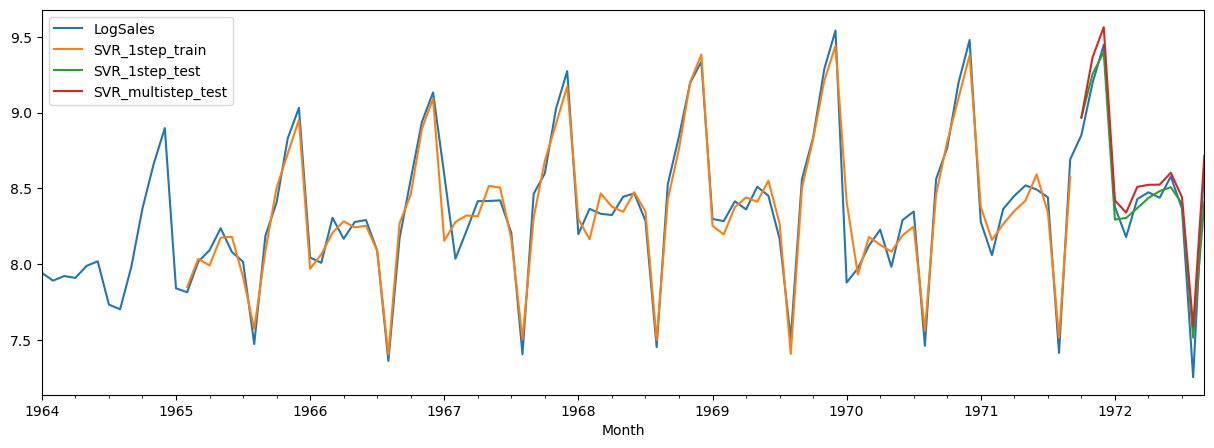

In [67]:
one_step_and_multistep_forecast_diff(SVR(), "SVR")

**With Support Vector Machines, the one-step forecast performs better than incremental multi-step.**

One-step forecast: RF
Train R^2: 0.9685839659934226
Test R^2 (1-step): 0.9482569501942955
Test MAPE (multi-step): 0.032595831798501194


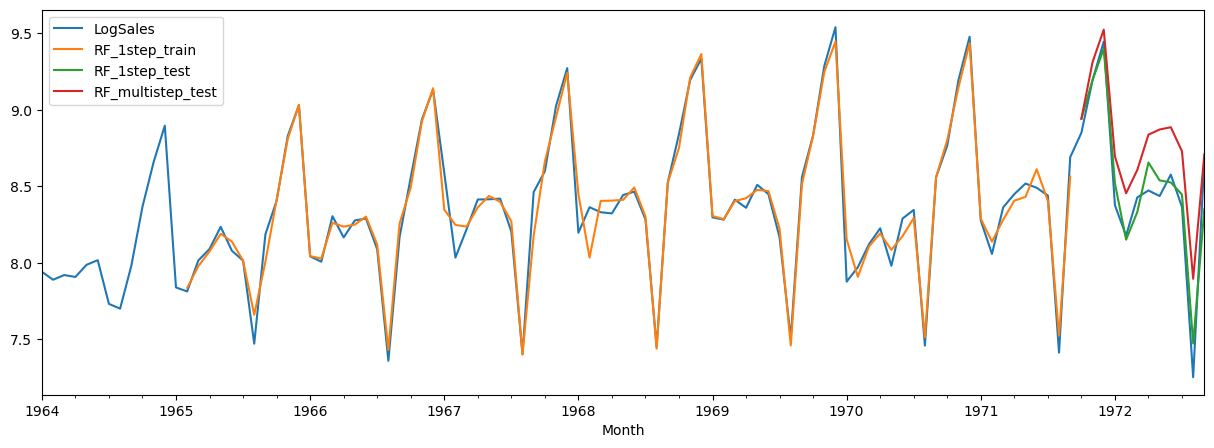

In [68]:
one_step_and_multistep_forecast_diff(RandomForestRegressor(), "RF")

**With Random Forests, again the one-step forecast performs best, but the incremental multi-step performs the worst it ever has.**

In [69]:
def multi_output_forecast_diff(model, name):
    model.fit(X_train_d, Y_train_d)
    
    # Save multi-output forecast to dataframe
    doc.loc[test_idx, f'{name}_multioutput'] = last_train + np.cumsum(model.predict(X_test_d).flatten())
    
    mape = mean_absolute_percentage_error(test_log_pass, doc.loc[test_idx, f'{name}_multioutput'])
    print("Test MAPE (multi-output):", mape)
    
    # Plot all forecasts, assuming all previous functions have been run
    cols = ['LogSales', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test', f'{name}_multioutput']
    doc[cols].plot(figsize=(15, 5));

Test MAPE (multi-output): 0.031839946959492306


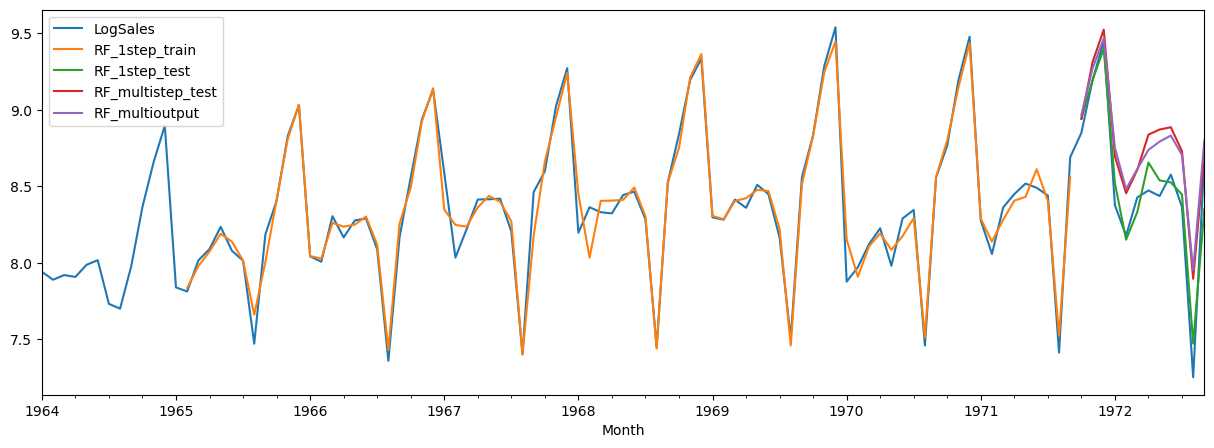

In [70]:
multi_output_forecast_diff(RandomForestRegressor(), "RF")

**Multi-output method improves results slightly for Random Forest model, but overall it is the worst regression model.**

**The one-step forecasts perform best for Support Vector Machine and Random Forests, with Support Vector Machine outperforming the Random Forest in general. But both are still not as good as Linear Regression model.**

**When the data is differenced, the best model choice is Linear Regression incremental multi-step forecasting, same as when the data is not differenced. However, when the data is not differenced, interestingly enough Linear Regression outperforms.**

**EXERCISE 1:** 

1. Compute MAPE for non-logged data (i.e. exponentiate predictions)
2. Compare with previous models (e.g. ARIMA, ETS)